In [ ]:

! unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: test/daisy/10466290366_cc72e33532_jpg.rf.6ddc91cd5d4a6a683e567ccb37e5a089.jpg  
  inflating: test/daisy/10466558316_a7198b87e2_jpg.rf.7acf642b94dc98daa49482a12994ac4c.jpg  
  inflating: test/daisy/12193032636_b50ae7db35_n_jpg.rf.e6c4eeb71c56e793a0d85f6d979dbe20.jpg  
  inflating: test/daisy/1342002397_9503c97b49_jpg.rf.8fe6bdd23186b70f089bb0c5b89d314e.jpg  
  inflating: test/daisy/1354396826_2868631432_m_jpg.rf.409eee37613d16dbc71365cb5615327e.jpg  
  inflating: test/daisy/1374193928_a52320eafa_jpg.rf.e398f632151f3ccc5729bc89527d7614.jpg  
  inflating: test/daisy/1392131677_116ec04751_jpg.rf.da99f9bb579ee96dc1728545ca519d6f.jpg  
  inflating: test/daisy/14333681205_a07c9f1752_m_jpg.rf.6ff96d9fe33f0bd19a18425f32d470b1.jpg  
  inflating: test/daisy/14399435971_ea5868c792_jpg.rf.89b733453e10d461d440acc99b7ef6d1.jpg  
  inflating: test/daisy/14564545365_1f1d267bf1_n_jpg.r

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix

**Set Global Constants**


In [ ]:
IMG_H = 224
IMG_W = 224
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
IMAGE_SHAPE = (IMG_H, IMG_W, 3)
FINE_TUNING_START = 75

**Load the Train, Test and Validation Datasets**

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/train",
    shuffle=True,
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/valid",
    shuffle=True,
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/test",
    shuffle=True,
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE
)

Found 1275 files belonging to 2 classes.
Found 364 files belonging to 2 classes.
Found 182 files belonging to 2 classes.


**Plot a Small Batch of the Train Dataset**

In [ ]:
class_names = train_dataset.class_names

## **Set Performance Helpers**


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## **Load the Base InceptionV3 Model**

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    include_top = False,
    input_shape=IMAGE_SHAPE,
    weights="imagenet"
)
base_model.trainable = False

base_model.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

## **Build the Classification Model**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE, batch_size=BATCH_SIZE),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

## **Compile the Classification Model**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

## **Fit the Classification Model on the Training Data**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can change this to 'loss' to monitor training loss
    patience=2,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min',
    min_delta=0.001
)

# Fit the model with the early stopping callback
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Add the callback here
)


Epoch 1/5
20/20 [==============================] - 26s 663ms/step - loss: 0.4982 - accuracy: 0.7490 - val_loss: 0.2484 - val_accuracy: 0.8846
Epoch 2/5
20/20 [==============================] - 4s 194ms/step - loss: 0.2958 - accuracy: 0.8706 - val_loss: 0.2152 - val_accuracy: 0.8929
Epoch 3/5
20/20 [==============================] - 3s 166ms/step - loss: 0.2472 - accuracy: 0.8933 - val_loss: 0.1897 - val_accuracy: 0.8984
Epoch 4/5
20/20 [==============================] - 3s 164ms/step - loss: 0.2257 - accuracy: 0.9012 - val_loss: 0.1690 - val_accuracy: 0.9066
Epoch 5/5
20/20 [==============================] - 3s 166ms/step - loss: 0.2115 - accuracy: 0.9067 - val_loss: 0.1558 - val_accuracy: 0.9231


## **Evaluate the Classification Model**

In [ ]:
loss, acc = model.evaluate(validation_dataset)

print("Accuracy: {:.2f}".format(acc))
print("Loss: {:.2f}".format(loss))

6/6 [==============================] - 1s 122ms/step - loss: 0.1558 - accuracy: 0.9231
Accuracy: 0.92
Loss: 0.16


Text(0.5, 1.0, 'Training and Validation Loss')

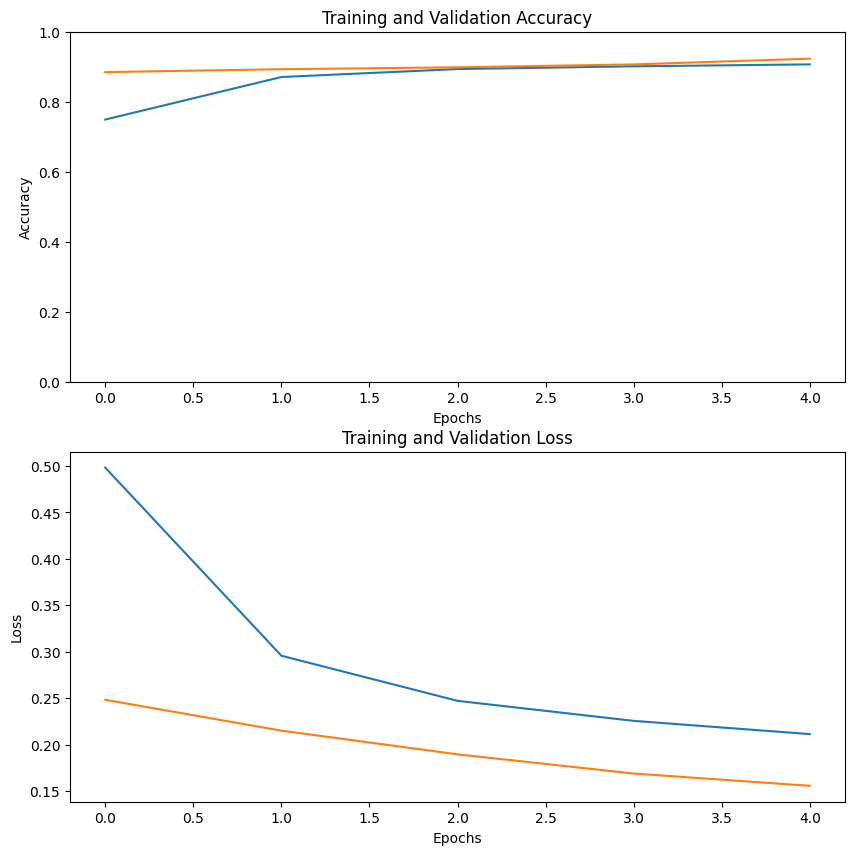

In [ ]:
accuracy = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
plt.plot(accuracy)
plt.plot(val_acc)
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_ylim([0, 1])
ax.set_title("Training and Validation Accuracy")

ax = plt.subplot(2,1,2)
plt.plot(loss)
plt.plot(val_loss)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")

## **Evaluate the Predictions on the Test Dataset**

In [ ]:
predictions = model.predict(test_dataset)

3/3 [==============================] - 6s 2s/step


In [ ]:
predicted_batch_labels = [(1 if prediction >= 0.5 else 0) for prediction in predictions]
predicted_batch_labels = np.asarray(predicted_batch_labels)[:64]

test_batch_labels = [label for image, label in test_dataset]
test_batch_labels = test_batch_labels[0]
test_batch_labels = np.asarray(test_batch_labels)

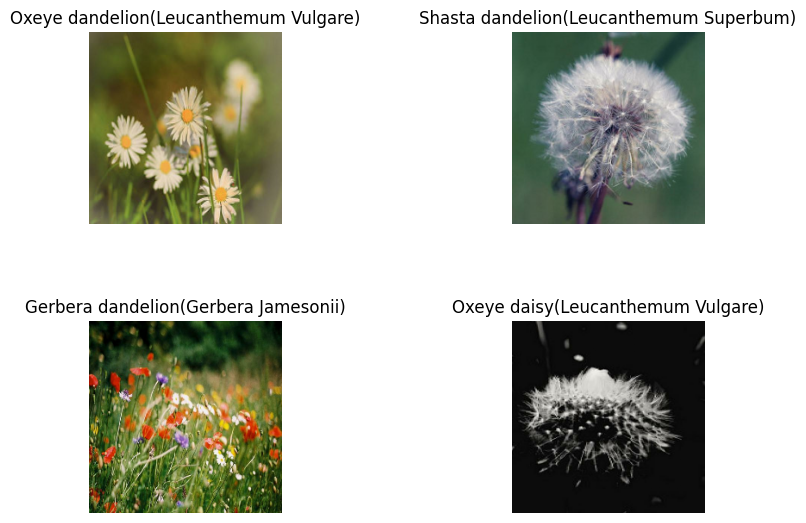

In [ ]:

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
for image_batch, _ in test_dataset.take(17):
  for i in range(4):
    plt.subplot(3, 2, i+1)
    plt.imshow(image_batch[i] / 255)
    if(i%3==0):
      plt.title("Oxeye "+class_names[predicted_batch_labels[i]]+"(Leucanthemum Vulgare)")
    elif(i%3==1):
      plt.title("Shasta "+class_names[predicted_batch_labels[i]]+"(Leucanthemum Superbum)")
    elif(i%3==2):
      plt.title("Gerbera "+class_names[predicted_batch_labels[i]]+"(Gerbera Jamesonii)")
    plt.axis("off")



## **Classification Report**

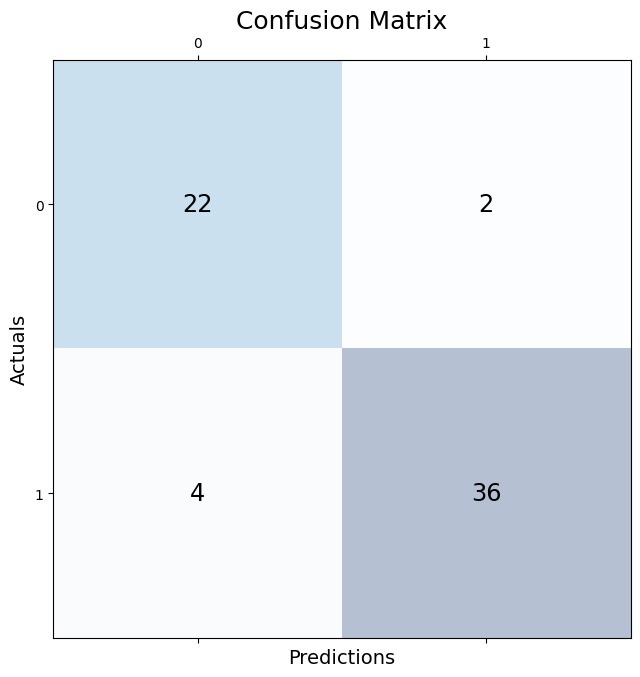

In [ ]:
conf_matrix = confusion_matrix(y_true=test_batch_labels, y_pred=predicted_batch_labels)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
tn, fp, fn, tp = conf_matrix.ravel()

print("True Positive (TP): ", tp)
print("True Negative (TN): ", tn)
print("False Positive (FP): ", fp)
print("False Negative (FN): ", fn)

accuracy = (tp + tn) / (tp + tn + fp + fn)

precision = (tp) / (tp + fp)

recall = (tp) / (tp + fn)

f1_score = (2 * (precision * recall)) / (precision + recall)

print("\n\nMetrics:")
print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1-score: ", round(f1_score, 2))

True Positive (TP):  36
True Negative (TN):  22
False Positive (FP):  2
False Negative (FN):  4


Metrics:
Accuracy:  0.91
Precision:  0.95
Recall:  0.9
F1-score:  0.92


In [ ]:
# Assume 'model' is your trained model
model.save('content/my_model.h5')  # Save as an HDF5 file


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 1s 1s/step


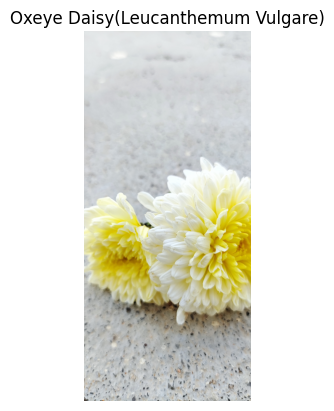

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from IPython.display import display
import ipywidgets as widgets
from io import BytesIO

# Assume class_names is a dictionary mapping class indices to class names
class_names = {
    0: "Oxeye Daisy",
    1: "Shast Daisy",
    2: "Gerbera Daisy"
}

# Load the pre-trained model (replace with your model's path or object)
model = tf.keras.models.load_model('/content/content/my_model.h5')

def load_and_preprocess_image(img):
    img = img.resize((224, 224))  # Adjust target_size as needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0,1]
    return img_array

def predict_image_class(img_array):
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    return predicted_class_idx

def display_image_with_prediction(img, predicted_class_idx):
    plt.imshow(img)
    plt.axis("off")

    if predicted_class_idx % 3 == 0:
        plt.title(class_names[predicted_class_idx]+"(Leucanthemum Vulgare)")
    elif predicted_class_idx % 3 == 1:
        plt.title(class_names[predicted_class_idx]+"(Leucanthemum Superbum)")
    elif predicted_class_idx % 3 == 2:
        plt.title(class_names[predicted_class_idx]+"(Gerbera Jamesonii)")

    plt.show()

# Create an upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    if len(change['new']) > 0:
        uploaded_file = next(iter(upload_widget.value.values()))
        img = image.load_img(BytesIO(uploaded_file['content']))

        # Load and preprocess the image
        img_array = load_and_preprocess_image(img)

        # Predict the class of the image
        predicted_class_idx = predict_image_class(img_array)

        # Display the image with the predicted class name
        display_image_with_prediction(img, predicted_class_idx)

upload_widget.observe(on_upload_change, names='value')
display(upload_widget)
